# Estimating Fluxes at Steady State

To estimate metabolic fluxes at steady state, we use nonlinear optimization to minimize the difference between the simulated and measured labeling patterns when the system reaches a stable status, both metabolically and isotopically. The problem can be formulated as follows:

![Optimization problem ><](images/ss_eqn.gif)

Here, ${\bf{x}}_{sim}$ and ${\bf{v}}_{sim}$ are simulated MDVs and fluxes, respectively, both the functions of free flux $\bf{u}$. ${\bf{x}}_{exp}$ and ${\bf{v}}_{exp}$ are the measured labeling patterns and fluxes, and ${\bf{\Sigma }}_{{{\bf{x}}_{exp}}}^{ - 1}$ and ${\bf{\Sigma }}_{{{\bf{v}}_{exp}}}^{ - 1}$ are the inverses of the covariance matrix of measurements. $\bf{N}$ is the null space of the stoichiometric matrix of the network reactions, and $\bf{T}$ is the matrix that transforms total fluxes to net fluxes.

## Solving the Fluxes

We will demonstrate the process using a toy model. First, we build the model by reading from the [file](https://github.com/Chaowu88/freeflux/tree/main/models/toy):

In [1]:
from freeflux import Model

MODEL_FILE = 'path/to/reactions.tsv'

model = Model('demo')
model.read_from_file(MODEL_FILE)

fit = model.fitter('ss')

Next, we specify the labeling strategy:

In [2]:
fit.set_labeling_strategy(
    'AcCoA', 
    labeling_pattern = ['01', '11'], 
    percentage = [0.25, 0.25], 
    purity = [1, 1]
)   # call this method for each labeled substrate

We can set the measurements using `set_measured_MDV` for MDV and `set_measured_flux` for flux (if any). To input a set of measurements, we can load from [files](https://github.com/Chaowu88/freeflux/tree/main/models/toy) using `set_measured_MDVs_from_file` and `set_measured_fluxes_from_file` methods. We assume here that the measured fluxes are net ones since total fluxes are not typically measurable:

In [3]:
MEASURED_MDV_FILE = 'path/to/measured_MDVs.tsv'
MEASURED_FLUX_FILE = 'path/to/measured_fluxes.tsv'

fit.set_measured_MDVs_from_file(MEASURED_MDV_FILE)
fit.set_measured_fluxes_from_file(MEASURED_FLUX_FILE)

We can then set the lower and upper bounds of net fluxes:

In [4]:
fit.set_flux_bounds(
    'all',   # "all" denotes all fluxes. use reaction ID for specific flux   
    bounds = [-100, 100]
) 

<div class="alert alert-info">

<b>Note:</b> <br></br> The upper bound should be great than the lower bound. Use `set_measured_flux` or `set_measured_fluxes_from_file` for equality assignment.

</div>

Finally, we can solve for the fluxes:

In [5]:
fit.prepare(n_jobs = 3)
res = fit.solve(
    solver = 'slsqp', 
    ini_fluxes = None, 
    fit_measured_fluxes = True
)
print(res.optimization_successful)


fitting [elapsed: 0:00:01]
True


Currently, FreeFlux offers two methods to solve the fitting problem: sequential least squares programming (solver = "slsqp") and the r-algorithm with adaptive space dilation (solver = "ralg"). To use the r-algorithm solver, OpenOpt is required, and you can find more details on how to install it [here](https://freeflux.readthedocs.io/en/latest/installation.html).

The argument "ini_fluxes" is used to input an initial guess for the fluxes, which can be obtained from the last successful optimization. This argument takes a Pandas [Series](https://pandas.pydata.org/docs/reference/api/pandas.Series.html) object or a .tsv/.xlsx file. A good initial guess can help with convergence. If you do not provide an initial guess, the solver will generate a random initial guess sampled from the feasible region of fluxes estimated by flux variability analysis [(FVA)](https://freeflux.readthedocs.io/en/latest/fba.html).

The argument "fit_measured_fluxes" determines whether the second flux item is included in the objective function of the above-formulated problem. Set this argument to *True* if you have measured exchange fluxes, such as substrate uptake rate, product secretion rate, or specific cell growth, and provided them with `set_measured_flux` or `set_measured_fluxes_from_file`. In this case, the estimated fluxes will have the same unit as the measured ones, which are typically mmol gCDW$^{-1}$ h$^{-1}$ or $\mu$mol gCDW$^{-1}$ s$^{-1}$. If you do not provide any measured flux, you can still provide a substrate uptake rate and fix its value at 100. In this case, the estimated fluxes will have relative values normalized to the substrate uptake rate.

Other arguments such as "tol" and "max_iters" control when the optimization stops, and "show_progress" controls whether to display the time elapsed during the optimization.

After optimization, the results are stored in the FitResults object, and the optimal objective can be accessed using the `opt_objective` attribute:

In [6]:
print(res.opt_objective)

0.002


You can access the optimal net and total fluxes using the `opt_net_fluxes` and `opt_total_fluxes` attributes:

In [7]:
print(res.opt_net_fluxes)

v1: 10.0
v2: 10.0
v3: 4.993
v4: 5.007
v5: 5.007
v6: 5.007
v7: 4.993


In [8]:
print(res.opt_total_fluxes)

v1: 10.0
v2: 10.0
v3: 4.993
v4: 5.007
v5: 5.007
v6_f: 69.119
v6_b: 64.112
v7: 4.993


You can check the goodness of fit using the normal probability plot of weighted residuals. You can generate this plot using the following command:

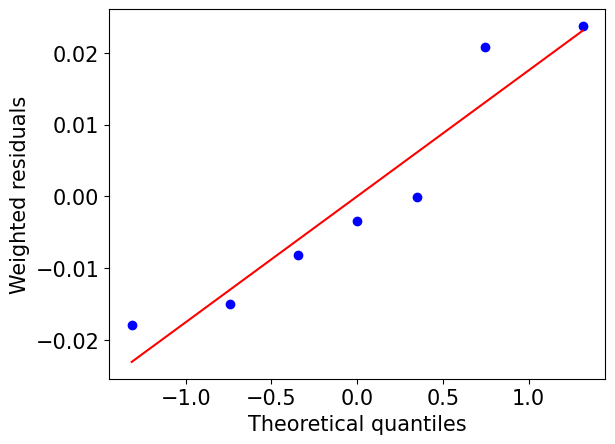

In [9]:
res.plot_normal_probability(show_fig = True, output_dir = None)

A good fit is indicated by the residuals closely following the red line, which represents a normal distribution.

We can also compare the simulated and experimental measurements by plotting them together using the command:

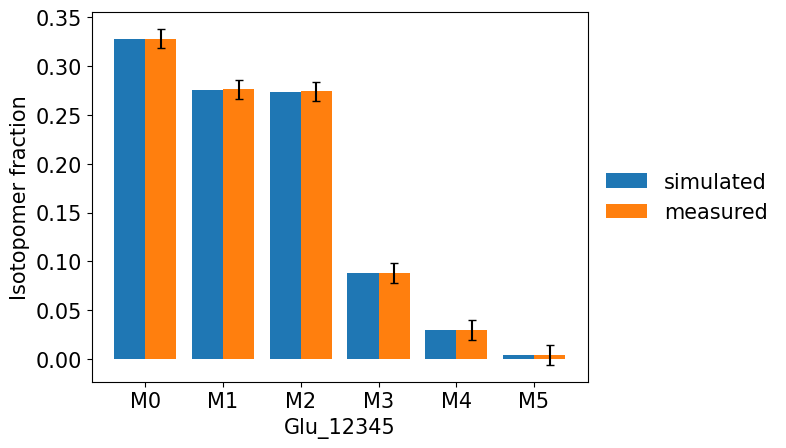

In [10]:
res.plot_simulated_vs_measured_MDVs(show_fig = True, output_dir = None)

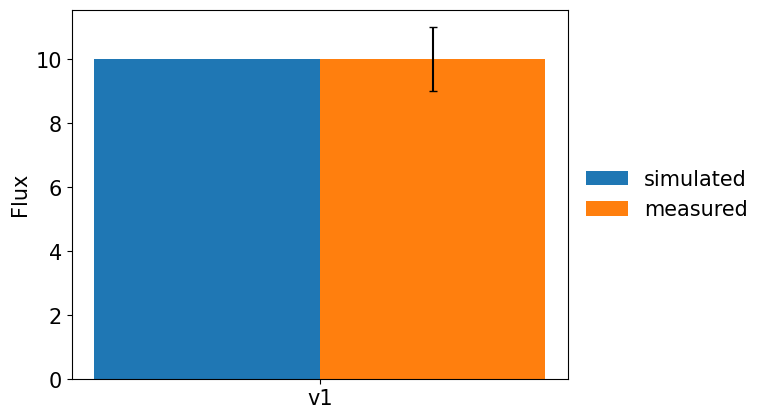

In [11]:
res.plot_simulated_vs_measured_fluxes(show_fig = True, output_dir = None)

To obtain symmetric confidence intervals of net or total fluxes at convergence, you can use the `estimate_confidence_intervals` method:

In [12]:
print(res.estimate_confidence_intervals(
    which = 'net',   # which = "total" for total fluxes
    confidence_level = 0.95
)) 

v1: [8.758, 11.242]
v2: [8.758, 11.242]
v3: [4.309, 5.677]
v4: [4.321, 5.693]
v5: [4.321, 5.693]
v6: [4.321, 5.693]
v7: [4.309, 5.677]


You can evaluate the contribution of measurement variances to the uncertainty of estimated fluxes by calculating the contribution matrix using the `get_contribution_matrix` method:

In [13]:
print(res.estimate_contribution_matrix(which = 'net')) # which = "total" for total fluxes

    Glu_12345_m0  Glu_12345_m1  Glu_12345_m2  Glu_12345_m3  Glu_12345_m4  \
v1  2.193959e-29  4.692641e-29  6.652732e-29  1.992930e-29  3.961689e-30   
v2  2.136664e-29  4.693636e-29  6.660495e-29  2.158797e-29  4.004388e-30   
v3  1.252988e-01  2.058794e-04  2.293547e-03  4.182729e-02  8.895606e-03   
v4  1.247228e-01  2.049330e-04  2.283004e-03  4.163501e-02  8.854712e-03   
v5  1.247228e-01  2.049330e-04  2.283004e-03  4.163501e-02  8.854712e-03   
v6  1.247228e-01  2.049330e-04  2.283004e-03  4.163501e-02  8.854712e-03   
v7  1.252988e-01  2.058794e-04  2.293547e-03  4.182729e-02  8.895606e-03   

    Glu_12345_m5        v1  
v1  1.194661e-31  1.000000  
v2  1.224363e-31  1.000000  
v3  4.665391e-04  0.821012  
v4  4.643944e-04  0.821835  
v5  4.643944e-04  0.821835  
v6  4.643944e-04  0.821835  
v7  4.665391e-04  0.821012  


we can also calculate the sensitivities of estimated fluxes to measurement perturbations using the following command:

In [14]:
print(res.estimate_sensitivity(which = 'net')) # which = "total" for total fluxes

    Glu_12345_m0  Glu_12345_m1  Glu_12345_m2  Glu_12345_m3  Glu_12345_m4  \
v1 -4.683972e-13 -6.850286e-13 -8.156428e-13 -4.464224e-13 -1.990399e-13   
v2 -4.622406e-13 -6.851011e-13 -8.161186e-13 -4.646285e-13 -2.001097e-13   
v3  1.950560e+01  7.906644e-01 -2.639001e+00 -1.126978e+01 -5.197248e+00   
v4 -1.950560e+01 -7.906644e-01  2.639001e+00  1.126978e+01  5.197248e+00   
v5 -1.950560e+01 -7.906644e-01  2.639001e+00  1.126978e+01  5.197248e+00   
v6 -1.950560e+01 -7.906644e-01  2.639001e+00  1.126978e+01  5.197248e+00   
v7  1.950560e+01  7.906644e-01 -2.639001e+00 -1.126978e+01 -5.197248e+00   

    Glu_12345_m5        v1  
v1 -3.456387e-14  1.000000  
v2 -3.499090e-14  1.000000  
v3 -1.190227e+00  0.499299  
v4  1.190227e+00  0.500701  
v5  1.190227e+00  0.500701  
v6  1.190227e+00  0.500701  
v7 -1.190227e+00  0.499299  


The `with` statement can also be used to perform flux estimation:

In [15]:
with model.fitter('ss') as fit:
    fit.set_labeling_strategy(
        'AcCoA', 
        labeling_pattern = ['01', '11'], 
        percentage = [0.25, 0.25], 
        purity = [1, 1]
    )
    fit.set_measured_MDVs_from_file(MEASURED_MDV_FILE)
    fit.set_measured_fluxes_from_file(MEASURED_FLUX_FILE)
    fit.prepare(n_jobs = 3)
    res = fit.solve(
        solver = 'slsqp', 
        ini_fluxes = None, 
        fit_measured_fluxes = True
    )
print(res.optimization_successful)


fitting [elapsed: 0:00:01]
True


A more complex example of steady state fitting using an *E. coli* model is provided in the script "[tutorial_ecoli_steady_state_estimation.py](https://github.com/Chaowu88/freeflux/tree/main/tutorials)"

## Dilution Parameter

In some cases, the fractional labeling (<sup>13</sup>C enrichment) of certain metabolites, such as amino acids, can be significantly lower than that of other metabolites. This could be due to the presence of unlabeled fractions introduced from the inoculum, inactive pool or media. To better fit the data, dilution parameters need to be added to the network.

For instance, we can add the following three reactions to account for the dilution effect of a metabolite A with three C atoms:

v1: 0A(abc) $\rightarrow$ As(abc)\
v2: 0Au(abc) $\rightarrow$ As(abc)\
v3: As(abc) $\rightarrow$ sink

Here, A represents the metabolite involved in metabolic reactions, Au represents the metabolically inactive (unlabeled) fraction, and As represents the pseudo-metabolite denoting the metabolite measured in samples. The zero coefficient in v1 and v2 ensures that the additional metabolites will have no effect on the mass balance of network reactions. The flux values of the reactions can be arbitrary, but the ratio v2/(v1+v2) is determined by the labeling patterns of A, Au, and As, and is estimated as the dilution parameter. These additional reactions are useful in accounting for the dilution effect of measured metabolites, such as amino acids. For unmeasured metabolites, such as CO$_2$, only one reaction is needed:

v1: 0Au(abc) $\rightarrow$ 0A(abc)

The zero coefficient on both sides excludes the reaction from mass balance, leaving it only to EMU decomposition.

To inform the decomposer about the unlabeled dilution source(s), i.e., "Au" in the above example, we can set the argument "dilution_from = 'Au'" in the `prepare` method.

## Solving the Fluxes with Confidence Intervals

In some cases, it is important to assess the uncertainty in estimated fluxes by calculating confidence intervals (CIs). FreeFlux utilizes the Monte Carlo method to estimate CIs. The commands for estimating fluxes with CIs are similar to those for flux estimation, except the method `solve_with_confidence_intervals` is used instead.

In [16]:
with model.fitter('ss') as fit:
    fit.set_labeling_strategy(
        'AcCoA', 
        labeling_pattern = ['01', '11'], 
        percentage = [0.25, 0.25], 
        purity = [1, 1]
    )
    fit.set_flux_bounds(
        'all', 
        bounds = [-100, 100]
    ) 
    fit.set_measured_MDVs_from_file(MEASURED_MDV_FILE)
    fit.set_measured_fluxes_from_file(MEASURED_FLUX_FILE)
    fit.prepare(n_jobs = 3)
    res = fit.solve_with_confidence_intervals(
        n_runs = 90, 
        n_jobs = 3
    )
print(res.estimate_confidence_intervals(
    which = 'net', 
    confidence_level = 0.95
))


fitting with CIs [elapsed: 0:00:21]

v1: [8.487, 11.602]
v2: [8.487, 11.602]
v3: [4.195, 6.155]
v4: [4.002, 5.806]
v5: [4.002, 5.806]
v6: [4.002, 5.806]
v7: [4.195, 6.155]


<div class="alert alert-info">

<b>Note:</b> <br></br> For the estimation of CIs for large-sized models, we strongly recommend running with parallel jobs. One can achieve this by setting the 'n_jobs' argument of the `solve_with_confidence_intervals` method to a value greater than 1.

</div>

A more complex example of estimating flux CIs of an *E. coli* model is provided in the script "[tutorial_ecoli_steady_state_estimation.py](https://github.com/Chaowu88/freeflux/tree/main/tutorials)"